<a href="https://colab.research.google.com/github/bvharshith/pws/blob/main/HDPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the path to your dataset directory
dataset_path = "/content/drive/MyDrive/dataset/hw_drawings/hw_drawings"

# 1. Load and Preprocess the Dataset
def load_dataset(dataset_path):
    X = []  # List to hold images
    y = []  # List to hold corresponding labels

    label_mapping = {}  # Dictionary to map folder names to numeric labels
    current_label = 0

    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        if os.path.isdir(folder_path):
            label_mapping[folder_name] = current_label
            current_label += 1
            label = label_mapping[folder_name]
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    # Load and preprocess image
                    img = cv2.imread(file_path)
                    img = cv2.resize(img, (224, 224))  # Resize to match CNN input size
                    img = img / 255.0  # Normalize pixel values to [0, 1]
                    X.append(img)
                    y.append(label)

    return np.array(X), np.array(y)

# 2. Splitting the Dataset
def split_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# 3. Define the CNN Model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 4. Model Training
def train_model(X_train, y_train, X_test, y_test, num_classes):
    input_shape = X_train.shape[1:]  # Shape of input images
    model = create_cnn_model(input_shape, num_classes)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    return model

# 5. Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict_classes(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", accuracy)

# Main Function
def main():
    # 1. Load and Preprocess the Dataset
    X, y = load_dataset(dataset_path)

    # 2. Splitting the Dataset
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # 3. Model Training
    num_classes = len(np.unique(y))
    model = train_model(X_train, y_train, X_test, y_test, num_classes)

    # 5. Model Evaluation
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Epoch 1/10
2/2 [==============================] - 8s 2s/step - loss: 3.5085 - accuracy: 0.4500 - val_loss: 2.8100 - val_accuracy: 0.3000
Epoch 2/10
2/2 [==============================] - 5s 1s/step - loss: 1.7005 - accuracy: 0.5000 - val_loss: 0.6995 - val_accuracy: 0.3000
Epoch 3/10
2/2 [==============================] - 4s 2s/step - loss: 0.6868 - accuracy: 0.5500 - val_loss: 0.8895 - val_accuracy: 0.3000
Epoch 4/10
2/2 [==============================] - 5s 1s/step - loss: 0.6880 - accuracy: 0.5500 - val_loss: 0.6087 - val_accuracy: 0.7000
Epoch 5/10
2/2 [==============================] - 4s 1s/step - loss: 0.8134 - accuracy: 0.4500 - val_loss: 0.7221 - val_accuracy: 0.3000
Epoch 6/10
2/2 [==============================] - 4s 1s/step - loss: 0.6970 - accuracy: 0.5500 - val_loss: 0.8841 - val_accuracy: 0.3000
Epoch 7/10
2/2 [==============================] - 5s 1s/step - loss: 0.7060 - accuracy: 0.5500 - val_loss: 0.7262 - val_accuracy: 0.3000
Epoch 8/10
2/2 [=========================

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
# 5. Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", accuracy)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# 1. Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# 2. Transfer Learning with Pre-trained Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using data augmentation
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10,
                    validation_data=(X_test, y_test))

# Evaluate the model
evaluate_model(model, X_test, y_test)


58889256/58889256 [==============================] - 0s 0us/step


NameError: name 'num_classes' is not defined

In [ ]:
def main():
    # 1. Load and Preprocess the Dataset
    X, y = load_dataset(dataset_path)

    # Define the number of classes
    num_classes = len(np.unique(y))

    # 2. Splitting the Dataset
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # 3. Data Augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # 4. Transfer Learning with Pre-trained Model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model using data augmentation
    history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch=len(X_train) / 32, epochs=10,
                        validation_data=(X_test, y_test))

    # Evaluate the model
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Epoch 1/10
1/1 [==============================] - 38s 129s/step - loss: 14.1860 - accuracy: 0.5250 - val_loss: 11.2525 - val_accuracy: 0.3000
Epoch 2/10
1/1 [==============================] - 31s 106s/step - loss: 6.2065 - accuracy: 0.4500 - val_loss: 3.2760 - val_accuracy: 0.7000
Epoch 3/10
1/1 [==============================] - 35s 120s/step - loss: 5.0504 - accuracy: 0.4500 - val_loss: 0.7919 - val_accuracy: 0.7000
Epoch 4/10
1/1 [==============================] - 41s 124s/step - loss: 1.0026 - accuracy: 0.6000 - val_loss: 3.2625 - val_accuracy: 0.3000
Epoch 5/10
1/1 [==============================] - 37s 66s/step - loss: 1.6362 - accuracy: 0.5500 - val_loss: 1.1177 - val_accuracy: 0.3000
Epoch 6/10
1/1 [==============================] - 36s 63s/step - loss: 0.6383 - accuracy: 0.6750 - val_loss: 0.6088 - val_accuracy: 0.7000
Epoch 7/10
1/1 [==============================] - 34s 55s/step - loss: 0.9264 - accuracy: 0.4500 - val_loss: 1.9266 - val_accuracy: 0.3000
Epoch 8/10
1/1 [=====

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Train the model using data augmentation
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10,
                    validation_data=(X_test, y_test))

# Plot training history
plot_training_history(history)


NameError: name 'model' is not defined

Epoch 1/10
1/1 [==============================] - 38s 66s/step - loss: 6.5191 - accuracy: 0.4500 - val_loss: 2.4411 - val_accuracy: 0.7000
Epoch 2/10
1/1 [==============================] - 36s 59s/step - loss: 3.5857 - accuracy: 0.6000 - val_loss: 10.1031 - val_accuracy: 0.3000
Epoch 3/10
1/1 [==============================] - 37s 127s/step - loss: 6.7636 - accuracy: 0.5500 - val_loss: 10.1537 - val_accuracy: 0.3000
Epoch 4/10
1/1 [==============================] - 34s 118s/step - loss: 6.0008 - accuracy: 0.5500 - val_loss: 7.9142 - val_accuracy: 0.3000
Epoch 5/10
1/1 [==============================] - 35s 60s/step - loss: 4.8088 - accuracy: 0.5500 - val_loss: 3.9327 - val_accuracy: 0.3000
Epoch 6/10
1/1 [==============================] - 36s 59s/step - loss: 2.1278 - accuracy: 0.5500 - val_loss: 0.6459 - val_accuracy: 0.7000
Epoch 7/10
1/1 [==============================] - 36s 124s/step - loss: 1.4019 - accuracy: 0.4500 - val_loss: 0.9878 - val_accuracy: 0.7000
Epoch 8/10
1/1 [======

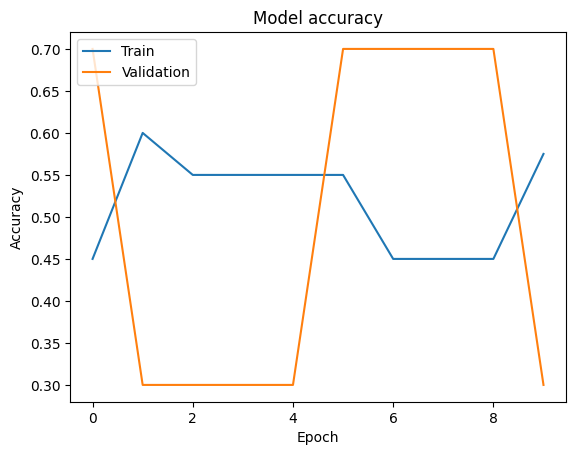

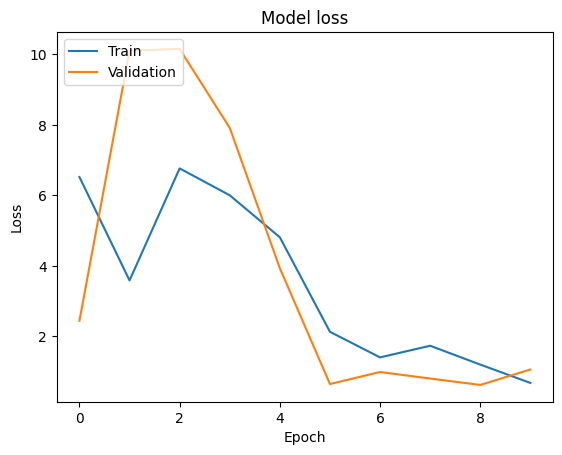

1/1 [==============================] - 6s 6s/step
Test Accuracy: 0.3


In [ ]:
def main():
    # 1. Load and Preprocess the Dataset
    X, y = load_dataset(dataset_path)

    # Define the number of classes
    num_classes = len(np.unique(y))

    # 2. Splitting the Dataset
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # 3. Data Augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # 4. Transfer Learning with Pre-trained Model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 5. Train the Model
    # Train the model using data augmentation
    history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch=len(X_train) / 32, epochs=10,
                        validation_data=(X_test, y_test))

    # 6. Plot Training History
    plot_training_history(history)

    # 7. Evaluate the Model
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Epoch 1/20
1/1 [==============================] - 35s 109s/step - loss: 17.9618 - accuracy: 0.5500 - val_loss: 8.0173 - val_accuracy: 0.3000
Epoch 2/20
1/1 [==============================] - 37s 119s/step - loss: 6.6775 - accuracy: 0.4000 - val_loss: 3.4265 - val_accuracy: 0.7000
Epoch 3/20
1/1 [==============================] - 37s 63s/step - loss: 5.5481 - accuracy: 0.4500 - val_loss: 0.7491 - val_accuracy: 0.7000
Epoch 4/20
1/1 [==============================] - 37s 65s/step - loss: 1.5504 - accuracy: 0.4500 - val_loss: 3.4819 - val_accuracy: 0.3000
Epoch 5/20
1/1 [==============================] - 35s 119s/step - loss: 2.0701 - accuracy: 0.5500 - val_loss: 1.3544 - val_accuracy: 0.3000
Epoch 6/20
1/1 [==============================] - 32s 107s/step - loss: 0.8315 - accuracy: 0.5000 - val_loss: 0.9042 - val_accuracy: 0.7000
Epoch 7/20
1/1 [==============================] - 41s 60s/step - loss: 1.3105 - accuracy: 0.4500 - val_loss: 0.6189 - val_accuracy: 0.7000
Epoch 8/20
1/1 [======

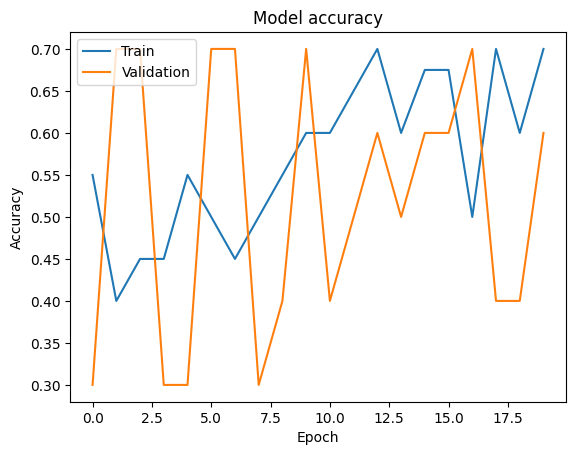

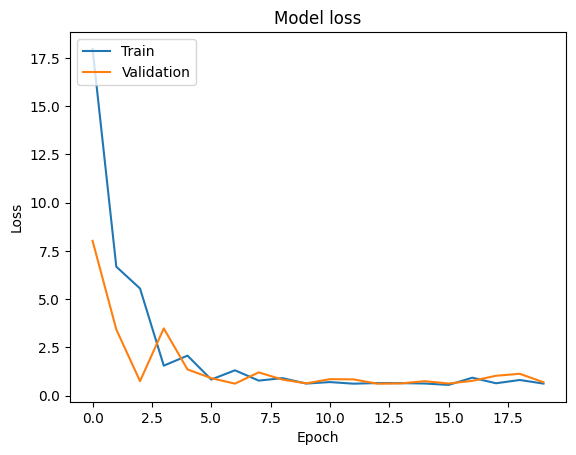

1/1 [==============================] - 6s 6s/step
Test Accuracy: 0.6


In [ ]:
def main():
    # 1. Load and Preprocess the Dataset
    X, y = load_dataset(dataset_path)

    # Define the number of classes
    num_classes = len(np.unique(y))

    # 2. Splitting the Dataset
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # 3. Data Augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # 4. Transfer Learning with Pre-trained Model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 5. Train the Model
    # Train the model using data augmentation
    history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch=len(X_train) / 32, epochs=20,  # Increase epochs to 20
                        validation_data=(X_test, y_test))

    # 6. Plot Training History
    plot_training_history(history)

    # 7. Evaluate the Model
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()
